# Modelos de Regresión Logística

## 1. Introducción a la Regresión Logística

Se trata de un **algoritmo estadístico** cuyo objetivo es aproximar una **función matemática acotada** en el intervalo [0, 1]. Así permite la estimación de las **probabilidades de pertenencia** de cada muestra a las distintas clases. Como la detección de sexismo es un problema de clasificación binario, se establece el umbral en 0.5 con el que asignar una clase a cada instancia aplicando las siguientes casuísticas:

* Si la probabilidad es **menor que 0.5** entonces la clase es **no sexista** (categoría 0). 
* Si la probabilidad es **mayor que 0.5** entonces la clase es **sexista** (categoría 1).

### 1.1. Condiciones de uso

* **Mínima correlación** entre los predictores o variables independientes.
* La existencia de una **relación lineal** entre los predictores y la probabilidad de cada variable dependiente.
* Mínima existencia de **outliers**.
* Conjunto de datos razonáblemente amplio.

### 1.2. Casos de uso

1. Construir **modelos lineales** para solventar problemas de clasificación cuyos datos son fácilmente separables.

2. Comprobar de la existencia de **relaciones lineales** entre los predictores y la variable dependiente en función de los valores de los coeficientes del hiperplano.

   - Si es 0 significa que **no existe una relación lineal** entre un predictor y la variable dependiente por lo que dicho predictor no ayuda en su predicción.

   - Si es mayor que 0 supone un crecimiento simultáneo del predictor al aumentar la variable dependiente, mientras que si es menor que 0 simboliza el incremento del predictor cuando disminuye la variable dependiente. Aunque en ambos casos el **predictor puede ser útil para predecir** la clase de una muestra.

## 2. Estructura del notebook

1. Introducción a la Regresión Logística
2. Estructura del notebook
3. Instalación y carga de librerías
4. Lectura y carga de datos
5. Técnicas de codificación de textos

## 3. Instalación y carga de librerías

Este apartado tiene como único propósito cargar las librerías y dependencias necesarias para la ejecución de este notebook, así como las funciones propiamente desarrolladas. Previo a ello deberán ser instaladas bien ejecutando el script *setup.sh* mediante el comando `bash setup.sh` con permisos de ejecución en distribuciones Linux, o bien ejecutando el compando `pip install -r requirements.txt`.

In [1]:
import sys
sys.path.append('../scripts')

# Import data read and compute functions
from data import read_training_dataset, read_testing_dataset

# Import text preprocess functions
from processing import *

# Import LR models and validation metrics
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# Import plot lib to show the confussion matrixes
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /home/lidia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 4. Lectura y carga de datos

En esta sección se pretende **cargar los datasets de entrenamiento y validación** procedentes de los correspondientes ficheros situados en la carpeta *data*. Al tener un **formato TSV** se deben leer como tablas aunque posteriormente se trabaje con ellos en formato *dataframe*. 

Tal y como se puede comprobar en los siguientes resultados las dimensiones de sendos conjuntos de datos se detallan a continuación:

* Conjunto de entrenamiento: **6.977 muestras**.
* Conjunto de validación: **4.368 muestras**.

In [2]:
# Read EXIST datasets
training_df = read_training_dataset()
testing_df = read_testing_dataset()

# Show the dimensions of the datasets
print("Training dataset dimensions:", training_df.shape)
print("Testing dataset dimensions:", testing_df.shape)

Training dataset dimensions: (6977, 7)
Testing dataset dimensions: (4368, 7)


## 5. Técnicas de codificación de textos

### 5.1. Bolsa de palabras

Es una técnica orientada a la **extracción de características** basado en **texto** que convierte cada documento en un vector de longitud fija a partir del cálculo de la frecuencia de sus términos. Si bien se trata de un procedimiento altamente sencillo y rápido de aplicar, **no** respeta el **orden de los términos** en los documentos y tampoco se considera el **contexto** de los mismos como consecuencia.

### 5.2. TF-IDF

Este procedimiento trata de codificar un conjunto de documentos considerando tanto la **frecuencia de los términos** en los textos como su **importancia relativa** con respecto a la población completa. Para ello calcula las frecuencias relativas y absolutas de todo el vocabulario disponible con las que posteriormente determinar el **grado de relevancia y representatividad** de los términos. Este método suele beneficiar con un mayor valor a aquellos conceptos con un menor número de ocurrencias. 

### 5.3. Word Embeddings

El cometido de este método consiste en codificar **documentos o palabras** como vectores numéricos capturando las **características contextuales** en base a sus relaciones, definiciones de términos, similitudes semánticas y sintácticas. La principal cualidad más destacable es su capacidad de **detectar entidades similares** y generar representaciones numéricas altamente parecidas. Si bien se pueden **entrenar modelos** completamente personalizados a conjuntos de datos, también existen **modelos pre-entrenados** con *word embeddings* ya generados listos para ser empleados en la codificación. Existen multitud de técnicas con diferentes enfoques para la creación de estas representaciones numéricas vectoriales, pero las que se emplean en este notebook se detallan a continuación:

* **Word2Vec**: es una de las técnicas más populares para codificar a nivel de palabras. 

   * **CBWO** (*Continuous Bag of Words*): esta primera arquitectura trata de predecir el siguiente término dentro de un contexto determinado. Se encuentra recomendada para **conjuntos de datos voluminosos** puesto que considera únicamente un vecindario de términos y tiende a representar mejor **conceptos frecuentes**.

   * **Skip-Gram**: esta segunda arquitectura trata de predecir los contextos asociados a un término de entrada. Puede ser empleada sobre **conjuntos de datos pequeños** para detectar **diferentes significados** por palabra.

## 6. Experimentos y modelos

A continuación se detallan los experimentos más relevantes de entre las distintas pruebas realizadas mediante diversas combinaciones de técnicas de procesamiento de textos, codificación de documentos y algoritmos clásicos de Aprendizaje Automático.

### 6.1. Primer experimento: Bolsa de palabras

- **Procesamiento** de los conjuntos de entrenamiento y validación, incluyendo las siguientes técnicas:

  - Elimina caracteres especiales, no alfabéticos y signos de puntuación.
  - Elimina hashtags y menciones de usuarios.
  - Elimina *stopwords* de los documentos en inglés y español.
  - Convierte todos los caracteres en minúsculas.
  - Convierte todos los términos a su raíz (**stemming**). Con esta técnica en particular el rendimiento del modelo aumenta únicamente en un 1% de *accuracy* y AUC aunque el **gasto temporal y computacional** es considerablemente **menor**.

- 
- **Codificación** de la variable dependiente *task1* a **etiquetas numéricas** en los conjuntos de entrenamiento y validación, estableciendo la asignación *non-sexist*~0 y *sexist*~1.

- Generación de una **bolsa de palabras** para entrenamiento y otra para validación como codificación de documentos en valores numéricos.

- Entrenamiento, hiperparametrización y validación con **Regresión Logística** para la construcción de varios modelos, siendo la siguiente configuración la que mejores resultados de validación ha conseguido:

  - **Regularización L1** es la penalización que ha conseguido el *accuracy* y área sobre la curva ROC más elevados gracias a su tendencia de minimizar los coeficientes a cero. Mientras que con la **regularización L2** se consiguen también unos **resultados similares**, si no se aplica penalización ambas métricas descienden más de 5 puntos. Por lo tanto se concluye que la **aplicación de regularización** para un modelo de tales características y sobre este conjunto de datos es necesaria para **reducir el overfitting**, ya que el *accuracy* de entrenamiento es muy superior al de validación.

  - El **valor de la penalización** establecido que mejor rendimiento proporciona se encuentra **muy cercano a cero**, siendo el intervalo posible [0, infinito]. Este hecho nos indica que para aumentar la capacidad de predicción de un modelo con Regresión Logística y el conjunto de datos EXIST2022, es necesario aplicar una **fortísima penalización** con motivo de **reducir el overfitting** que tiende a aparecer.

In [8]:
# Text processing in training and testing datasets
training_df = text_processing_pipeline(training_df, "text", stemm=True, language_col="language")
testing_df = text_processing_pipeline(testing_df, "text", stemm=True, language_col="language")

# Encode the class labels to numeric values for training and testing datasets providing the desirable assignation
encoding = {"non-sexist": 0, "sexist": 1}
encoded_training_labels = encode_to_numeric_labels(training_df, "task1", encoding)
encoded_testing_labels = encode_to_numeric_labels(testing_df, "task1", encoding)

# Train a CountVectorizer object to encode texts as bag of words for training and testing datasets
bag_words = to_bag_of_words(list(training_df["cleaned_text"].values), 
                            list(testing_df["cleaned_text"].values))

# Create and configure a LR model
lr_model1 = LogisticRegression(multi_class="ovr", solver="liblinear", penalty="l1", C=0.3)

# Train the LR model
lr_model1.fit(bag_words["training"], encoded_training_labels)

# Predict the testing labels with the trained LR model
training_predictions = lr_model1.predict(bag_words["training"])
testing_predictions = lr_model1.predict(bag_words["testing"])

Tal y como se observa en los siguientes resultados que representan la validación del modelo, sobre el conjunto de **entrenamiento** consigue un **77% de aciertos**, mientras que para el de **test** únicamente alcanza un **70% de aciertos**. Por lo tanto no se puede considerar un modelo competente puesto que al intentar identificar un texto como sexista o no sexista falla prácticamente un 30% del total de muestras. 

Si se estudia la matriz de confusión se aprecia la existencia de una **concentración de falsos negativos**, puesto que más de ochocientos **textos sexistas no han sido detectados** por el modelo. Este fenómeno ya se anticipaba durante la recopilación de información sobre los conjuntos de datos, ya que dependiendo del lenguaje utilizado en los documentos, su identificación puede llegar a ser bastante compleja de realizar automáticamente.

Training accuracy 0.777
Test accuracy 0.708
AUC 0.712


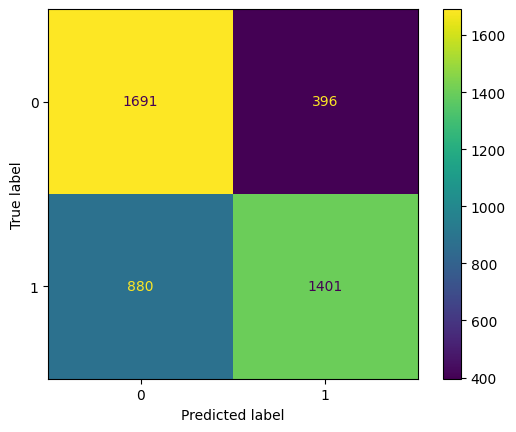

In [9]:
# LR model validation
print("Training accuracy %.3f" %metrics.accuracy_score(encoded_training_labels, training_predictions))
print("Test accuracy %.3f" %metrics.accuracy_score(encoded_testing_labels, testing_predictions))
print("AUC %.3f" %metrics.roc_auc_score(encoded_testing_labels, testing_predictions))
conf_matrix = metrics.confusion_matrix(encoded_testing_labels, testing_predictions)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lr_model1.classes_).plot()
plt.show()

### 6.2. Segundo experimento: TF-IDF

La configuración tanto de los datasets como del modelo son idénticas a las explicadas en el anterior experimento, a excepción de los dos siguientes aspectos:

* La **codificación de textos** se ha realizado aplicando la técnica denominada **TF-IDF**. 

* La **regularización** escogida en este caso ha sido la **L2** con un valor de penalización por defecto establecido en 1.0 puesto que al aumentarlo (menos penalización) el sobreajuste incrementaba considerablemente, mientas que al decrementar el valor (más penalización) el rendimiento del modelo empeoraba ligeramente.

In [28]:
# Text processing in training and testing datasets
training_df = text_processing_pipeline(training_df, "text", stemm=True, language_col="language")
testing_df = text_processing_pipeline(testing_df, "text", stemm=True, language_col="language")

# Encode the class labels to numeric values for training and testing datasets providing the desirable assignation
encoding = {"non-sexist": 0, "sexist": 1}
encoded_training_labels = encode_to_numeric_labels(training_df, "task1", encoding)
encoded_testing_labels = encode_to_numeric_labels(testing_df, "task1", encoding)

# Train a CountVectorizer object to encode texts as bag of words for training and testing datasets
bag_words = to_tf_idf(list(training_df["cleaned_text"].values), 
                            list(testing_df["cleaned_text"].values))

# Create and configure a LR model
lr_model2 = LogisticRegression(multi_class="ovr", solver="liblinear")

# Train the LR model
lr_model2.fit(bag_words["training"], encoded_training_labels)

# Predict the testing labels with the trained LR model
training_predictions = lr_model2.predict(bag_words["training"])
testing_predictions = lr_model2.predict(bag_words["testing"])

Tal y como se puede observar en los siguientes resultados, este segundo modelo parece caracterizarse por un **mayor sobreajuste** que el anterior puesto que la tasa de aciertos de entrenamiento es más de 14 puntos con respecto al conjunto de test. Un aspecto interesante ha sido la posibilidad de ajustar la configuración de entrenamiento obteniendo distintos resultados tras involucrar a una nueva técnica de codificación de textos. Con la misma **configuración anterior** el modelo del segundo experimento disponía de un **menor sobreajuste pero también un menor rendimiento**, mientras que con esta nueva configuración se dispara la tasa de aciertos en entrenamiento mientras que se resiente considerablemente en validación.

Training accuracy 0.876
Test accuracy 0.710
AUC 0.713


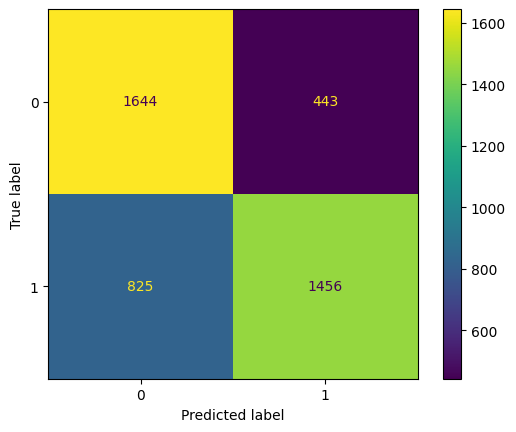

In [29]:
# LR model validation
print("Training accuracy %.3f" %metrics.accuracy_score(encoded_training_labels, training_predictions))
print("Test accuracy %.3f" %metrics.accuracy_score(encoded_testing_labels, testing_predictions))
print("AUC %.3f" %metrics.roc_auc_score(encoded_testing_labels, testing_predictions))
conf_matrix = metrics.confusion_matrix(encoded_testing_labels, testing_predictions)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lr_model2.classes_).plot()
plt.show()

### 6.3. Tercer experimento: Word Embeddings generados

En este último experimento de nuevo la configuración de los conjuntos de datos es similar a las anteriores así como la del propio modelo de Regresión Logística, destacando los siguientes aspectos:

* La **codificación de textos** se ha realizado aplicando la técnica denominada **Word2Vec** para generar *word embeddings* personalizados a los datasets. 

* La **regularización** escogida en este caso ha sido la **L2** puesto que se presenta una casuística parecida a la explicada en el experimento anterior.

In [87]:
# Text processing in training and testing datasets
training_df = text_processing_pipeline(training_df, "text", stemm=True, language_col="language")
testing_df = text_processing_pipeline(testing_df, "text", stemm=True, language_col="language")

# Encode the class labels to numeric values for training and testing datasets providing the desirable assignation
encoding = {"non-sexist": 0, "sexist": 1}
encoded_training_labels = encode_to_numeric_labels(training_df, "task1", encoding)
encoded_testing_labels = encode_to_numeric_labels(testing_df, "task1", encoding)

# Train a Word2Vec model to create word embeddings for training and testing datasets
word2vec = word2vec_pipeline(training_df, "cleaned_text", testing_df, "cleaned_text",
                                vector_size=500, window=2, min_count=4, epochs=7, algorithm=0)

# Create and configure a LR model
lr_model3 = LogisticRegression(multi_class="ovr", solver="liblinear")

# Train the LR model
lr_model3.fit(word2vec["training"], encoded_training_labels)

# Predict the testing labels with the trained LR model
training_predictions = lr_model3.predict(word2vec["training"])
testing_predictions = lr_model3.predict(word2vec["testing"])

Tras probar diversos valores para los distintos parámetros de la codificación de textos se han podido obtener las siguientes conclusiones:

* El rango para el parámetro *vector_size* se encuentra entre 300 y 400 por lo que es necesario aumentar el tamaño de los embeddings para almacenar una **mayor cantidad de vocabulario** con la que posteriormente codificar los documentos de una manera más precisa y sin perder tanta información que con longitudes menores.

* El valor del parámetro *min_count* también es relevante puesto que si **aumenta demasiado el vocabulario** puede contener **demasiado ruido** y por ende las representaciones resultantes perjudican el rendimiento del clasificador. No obstante, si el valor es muy elevado el **vocabulario se reduce drásticamente perdiendo información**.

* Una situación similar ocurre con el número de **iteraciones** puesto que a **mayor número, más sobreajuste** puesto que mayor es la diferencia entre los aciertos de entrenamiento y validación, aunque si se **decrementa demasiado** el modelo puede no tener suficiente tiempo como para estudiar los datos y perder información **disminuyendo su rendimiento**.

* Finalmente en relación al algoritmo utilizado para la codificación ha sido **CBWO** el que mejores resultados ha proporcionado siendo hasta un 5% más elevado en las tres métricas escogidas con respecto al algoritmo Skip-Gram. Por lo tanto para este conjunto de datos y utilizando Regresión Logística, es más factible intentar **predecir el siguiente término a partir del contexto** que no aplicando la arquitectura inversa.

Aún así las métricas reflejan un **clasificador prácticamente aleatorio** con muchísima menor capacidad de predicción que los anteriores que emplean otras codificaciones de textos. A diferencia de los experimentos anteriores, en este se presenta una **desmesurada tasa de falsos positivos**, es decir, textos no sexistas clasificados como positivos.

Training accuracy 0.548
Test accuracy 0.542
AUC 0.531


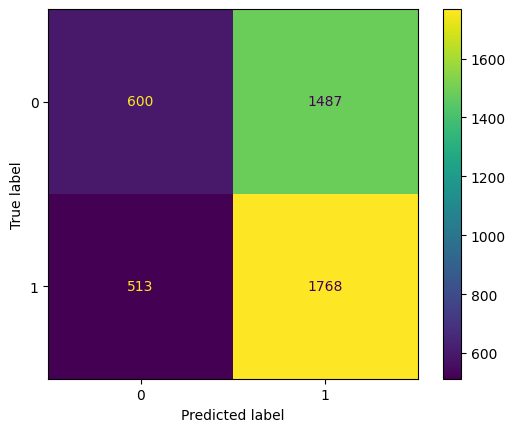

In [88]:
# LR model validation
print("Training accuracy %.3f" %metrics.accuracy_score(encoded_training_labels, training_predictions))
print("Test accuracy %.3f" %metrics.accuracy_score(encoded_testing_labels, testing_predictions))
print("AUC %.3f" %metrics.roc_auc_score(encoded_testing_labels, testing_predictions))
conf_matrix = metrics.confusion_matrix(encoded_testing_labels, testing_predictions)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lr_model3.classes_).plot()
plt.show()